<h1>Frame Buckling Analysis in OpenSeesPy</h1>
<h3>Authors: Luigi Caglio and Michael H. Scott</h3>
<p>
    June 2021
    <p>
    This notebook describes the elastic frame buckling computations developed by Luigi Caglio.<br>
    The original idea was posted as a reply to a post in the OpenSees Facebook group and the steps were then summarized in this <A HREF="https://portwooddigital.com/2021/05/29/right-under-your-nose/">blog post</A>.
</p>

<h2>Computational Procedure</h2>
<p>As described in the blog post, the following steps are required in order to compute buckling loads.</p>
<h3>1. Define the model</h3>
<p>Define a frame model with geometric nonlinearity. This can be either a corotational mesh of elastic elements (either elasticBeamColumn or disp/forceBeamColumn with elastic sections) or elements with geometric nonlinearity "inside the basic system" (forceBeamColumnCBDI, dispBeamColumnNL, mixedBeamColumn, etc. with elastic sections).</p>
<h3>2. Obtain the material stiffness matrix</h3>
<p>Before applying any loads to the model, use printA to get the stiffness matrix.</p>
<h3>3. Obtain the geometric stiffness matrix</h3>
<p>Now apply reference axial loads to the model, use printA again to get the geometric stiffness matrix.</p>
<h3>4. Eigenvalue analysis</h3>
<p>Solve the generalized eigenvalue problem using numpy.slin.eig(). The returned eigenvalues give the critical buckling loads and the eigenvectors give the buckled shapes.</p>

### Example Frame Structure

The computational steps will be demonstrated for the frame shown below.

<img src="https://portwoodhome.files.wordpress.com/2021/05/framebuckling-1.png?w=605">

In [56]:
import openseespy.opensees as ops
import openseespy.preprocessing.DiscretizeMember as dm

import matplotlib.pyplot as plt
import openseespy.postprocessing.ops_vis as opsv

import numpy as np
import scipy.linalg as slin

#plt.rc('text',usetex=True)
#plt.rc('font',family='serif')

%matplotlib notebook

<h3>Units and Material Properties</h3>

In [57]:
inch = 1
kip = 1

ft = 12*inch
ksi = kip/inch**2

E = 29000*ksi

### Main OpenSees code

<IPython.core.display.Javascript object>


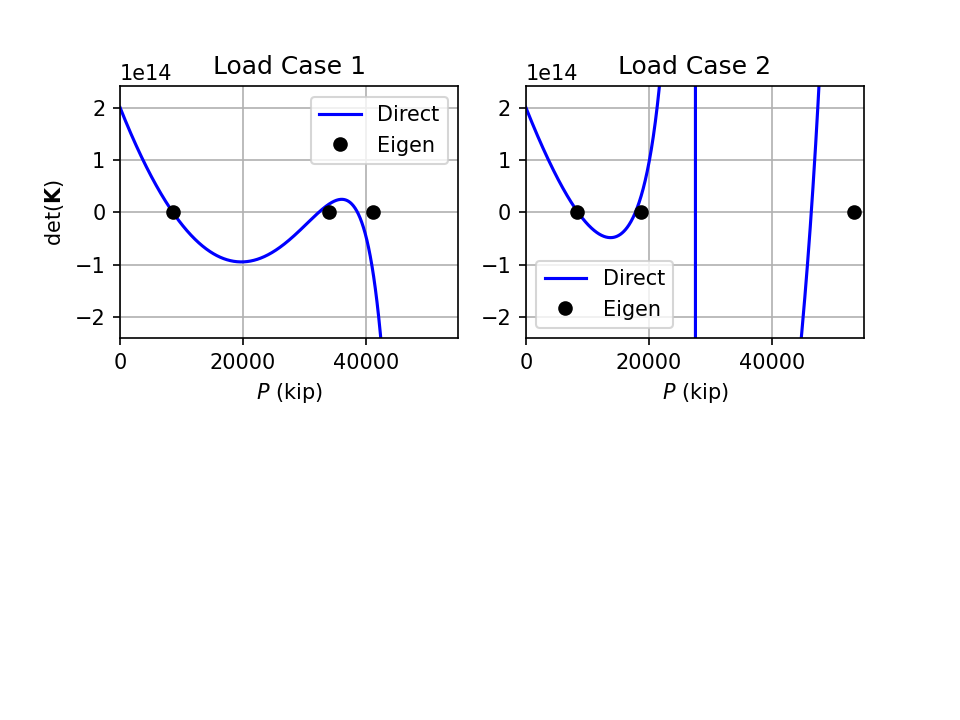

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [58]:
# Creating a figure
plt.figure()

# Loop through two load cases
for lc in [1,2]:

    ops.wipe()
    ops.model('basic','-ndm',2,'-ndf',3)

    L = 12*ft
    H = 30*ft
    Lc = L
    Lg = H
    
    ops.node(1,0,0); ops.fix(1,1,1,1)
    ops.node(2,0,L)
    ops.node(3,H,L)
    ops.node(4,H,0); ops.fix(4,1,1,1)

    # W14x90
    A = 26.5
    Ic = 999
    ops.section('Elastic',1,E,A,Ic)
    ops.beamIntegration('Legendre',1,1,2)

    # W18x76
    A = 22.3
    Ig = 1330
    ops.section('Elastic',2,E,A,Ig)
    ops.beamIntegration('Legendre',2,2,2)

    # Corotational transformation
    ops.geomTransf('Corotational',1)

    # Number of elements/member
    Nele = 8

    # Columns
    dm.DiscretizeMember(1,2,Nele,'dispBeamColumn',1,1,10,10)
    dm.DiscretizeMember(3,4,Nele,'dispBeamColumn',1,1,30,30)

    # Beam
    dm.DiscretizeMember(2,3,Nele,'dispBeamColumn',2,1,20,20)

    ops.numberer('RCM')
    ops.system('FullGeneral')
    ops.constraints('Plain')
    ops.integrator('LoadControl',0)
    ops.test('NormUnbalance',1e-8,10,0)
    ops.algorithm('Newton')
    ops.analysis('Static')

    
    # Analyze with no loads
    ops.analyze(1)

    # Get number of equations
    N = ops.systemSize()

    # Get material stiffness
    Kmat = ops.printA('-ret')
    Kmat = np.array(Kmat)
    Kmat.shape = (N,N)

    # Apply reference loads
    ops.timeSeries('Constant',1)
    ops.pattern('Plain',1,1)
    if lc == 1:
        ops.load(2,0,-1.0,0)
        ops.load(3,0,-1.0,0)
    if lc == 2:
        ops.load(2,0,-2.0,0)

    # Analyze for reference loads
    ops.analyze(1)

    # Get geometric stiffness
    Kgeo = ops.printA('-ret')
    Kgeo = np.array(Kgeo)
    Kgeo.shape = (N,N)
    Kgeo = Kmat-Kgeo

    # Eigenvalue analysis, and sorting
    lam, x = slin.eig(Kmat,Kgeo)
    lamSort = np.sort(lam[lam>0])

    # for plotting mode shapes later in the notebook
    if lc == 1:
        x_lc1 = x
        lam_lc1 = lam
    if lc == 2:
        x_lc2 = x
        lam_lc2 = lam 
        
        
    #    
    # Now get "exact" solution for this load case
    # We are using direct assembly with exact stability functions for the columns
    #    
    Kmat = np.zeros((3,3))
    
    if lc == 1:
        l1 = 1
        l3 = 1
    if lc == 2:
        l1 = 2
        l3 = 0
        
            
    Pplot = []
    Kplot = []
    
    Pmax = 55000*kip
    Nsteps = 1000
    dP = Pmax/Nsteps

    # Axial load
    P = 0
    while P <= Pmax:

        # Element 1
        psi = Lc*(l1*P/(E*Ic))**0.5
        if psi > 0:
            B1 = (psi*np.sin(psi)-psi**2*np.cos(psi))/(2*(1-np.cos(psi))-psi*np.sin(psi))
            C1 = (psi**2-psi*np.sin(psi))/(2*(1-np.cos(psi))-psi*np.sin(psi))
        else: 
            # Regular 4EI/L and 2EI/L from linear structural analysis
            B1 = 4
            C1 = 2

        # Element 3
        psi = Lc*(l3*P/(E*Ic))**0.5
        if psi > 0:
            B3 = (psi*np.sin(psi)-psi**2*np.cos(psi))/(2*(1-np.cos(psi))-psi*np.sin(psi))
            C3 = (psi**2-psi*np.sin(psi))/(2*(1-np.cos(psi))-psi*np.sin(psi))
        else:
            # Regular 4EI/L and 2EI/L from linear structural analysis
            B3 = 4
            C3 = 2

        # Direct assembly of stiffness matrix for this level of axial loads
        Kmat[0,0] = 2*(B1+C1)*E*Ic/Lc**3 + 2*(B3+C3)*E*Ic/Lc**3 - l1*P/Lc - l3*P/Lc
        Kmat[1,0] = (B1+C1)*E*Ic/Lc**2
        Kmat[2,0] = (B3+C3)*E*Ic/Lc**2

        Kmat[0,1] = Kmat[1,0]
        Kmat[1,1] = B1*E*Ic/Lc + 4*E*Ig/Lg
        Kmat[2,1] = 2*E*Ig/Lg

        Kmat[0,2] = Kmat[2,0]
        Kmat[1,2] = Kmat[2,1]
        Kmat[2,2] = B3*E*Ic/Lc + 4*E*Ig/Lg

        Pplot.append(P)
        Kplot.append(np.linalg.det(Kmat)) # When determinant is zero, we know the value of P is critical

        P += dP

    plt.subplot(2,2,lc)
    plt.plot(Pplot,Kplot,'b-',markersize=1,label='Direct')
    Nmodes = 3
    plt.plot(lamSort[:Nmodes],[0]*Nmodes,'ko',label='Eigen')   
    plt.grid()
    plt.xlim([0,Pmax])
    plt.xlabel('$P$ (kip)')
    plt.ylim(-1.2*Kplot[0],1.2*Kplot[0])
    if lc == 1:
        plt.ylabel('$\det({\\bf K})$')
    plt.title(f'Load Case {lc}')
    plt.legend()

<IPython.core.display.Javascript object>


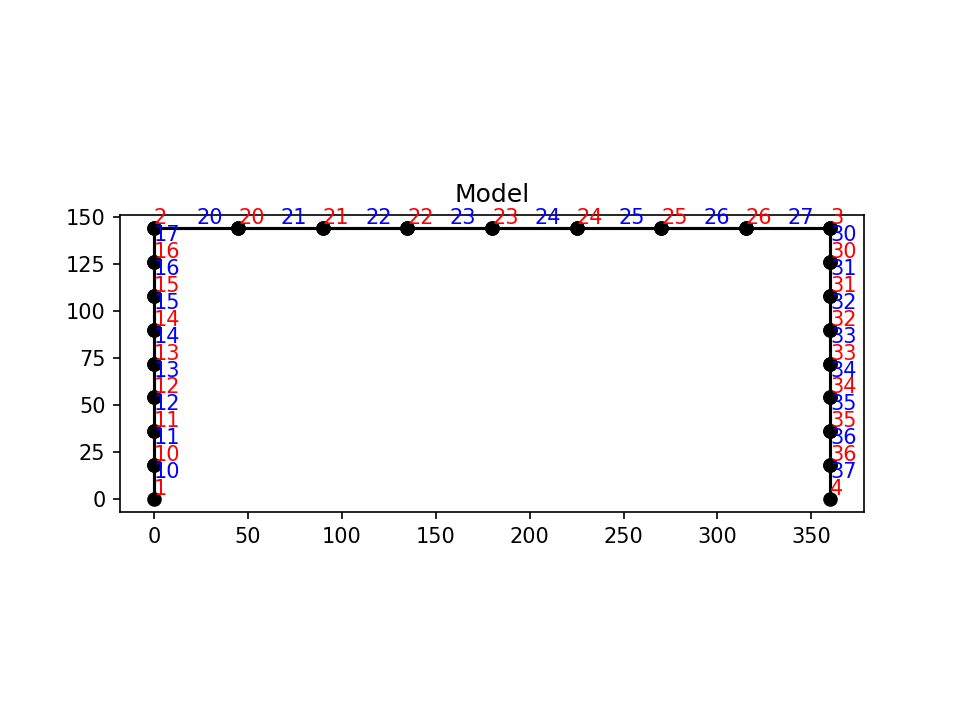

In [59]:
# draw model:
import eSEESminiPy
eSEESminiPy.drawModel()

# Sort mode shapes for plotting

In [60]:
# function to sort lambda and modeshape vectors accordingly
    
def sortModes(lam,x):
    
    #sort lambda and x
    lambda_sorted = np.sort(lam)
    lambda_inds = lam.argsort()
    x_Sort = np.zeros_like(x)
    
    for count, index in enumerate(lambda_inds):
        x_Sort[:,count]=x[:,index]

    
    #only modes with positive lambda
    index = 0
    while index<len(lambda_sorted) and lambda_sorted[index]<0:
        index+=1
    lamSort = lambda_sorted[index:]
    x_Sort  = x_Sort[:,index:]
    
    return lamSort,x_Sort

In [61]:
lam_lc1, x_lc1 = sortModes(lam_lc1,x_lc1) 
lam_lc2, x_lc2 = sortModes(lam_lc2,x_lc2) 

# Function to plot mode shapes

In [62]:
# function to plot the mode shapes
# from https://github.com/zhuminjie/OpenSeesPyDoc/blob/master/src/ops_vis/ops_vis.py

# default settings

# fmt: format string setting color, marker and linestyle
# check documentation on matplotlib's plot

# continuous interpolated shape line
fmt_interp = 'b-'  # blue solid line, no markers

# element end nodes
fmt_nodes = 'rs'  # red square markers, no line

# deformed model
fmt_defo = 'b-'  # green dashed line, no markers

# undeformed model
fmt_undefo = 'g:'  # green dotted line, no markers

# section forces
fmt_secforce = 'b-'  # blue solid line

# figure left right bottom top offsets
fig_lbrt = (.04, .04, .96, .96)

# azimuth and elevation in degrees
az_el = (-60., 30.)

# figure width and height in centimeters
fig_wi_he = (16., 10.)

#sfac=False

nep=17
unDefoFlag=1
fmt_undefo='g:'
interpFlag=1
endDispFlag=0
fmt_interp='b-'
fmt_nodes='rs'
Eo=0,
az_el=(-60.0, 30.0)
fig_wi_he=(16.0, 10.0)
fig_lbrt=(0.04, 0.04, 0.96, 0.96)

def plot_buckling_mode(mode,lambda_,vec,scalefac=10):  # modified from   _plot_defo_mode_2d    function
    sfac=scalefac
    
    ele_tags = ops.getEleTags()
    #plt.figure()
    for ele_tag in ele_tags:
        nd1, nd2 = ops.eleNodes(ele_tag)
        
        DOFs_nd1 = ops.nodeDOFs(nd1)
        DOFs_nd2 = ops.nodeDOFs(nd2)
        # element x, y coordinates
        ex = np.array([ops.nodeCoord(nd1)[0],
                       ops.nodeCoord(nd2)[0]])
        ey = np.array([ops.nodeCoord(nd1)[1],
                       ops.nodeCoord(nd2)[1]])
    
        #if modeNo:
        if DOFs_nd1[0] != -1:
            ed1 = -vec[DOFs_nd1[0],mode]
        else:
            ed1 = 0  
        if DOFs_nd1[1] != -1:
            ed2 = -vec[DOFs_nd1[1],mode]
        else:
            ed2 = 0  
        if DOFs_nd1[2] != -1:
            ed3 = -vec[DOFs_nd1[2],mode]
        else:
            ed3 = 0  
        if DOFs_nd2[0] != -1:
            ed4 = -vec[DOFs_nd2[0],mode]
        else:
            ed4 = 0  
        if DOFs_nd2[1] != -1:
            ed5 = -vec[DOFs_nd2[1],mode]
        else:
            ed5 = 0  
        if DOFs_nd2[2] != -1:
            ed6 = -vec[DOFs_nd2[2],mode]
        else:
            ed6 = 0  
        
        ed = np.array([ed1,
                       ed2,
                       ed3,
                       ed4,
                       ed5,
                       ed6])
    
        if unDefoFlag:
            plt.plot(ex, ey, fmt_undefo)
    
        # interpolated displacement field
        if interpFlag:
            xcdi, ycdi = opsv.beam_defo_interp_2d(ex, ey, ed, sfac, nep)
            plt.plot(xcdi, ycdi, fmt_interp)
    
        # translations of ends
        if endDispFlag:
            xdi, ydi = opsv.beam_disp_ends(ex, ey, ed, sfac)
            plt.plot(xdi, ydi, fmt_nodes)
    
    plt.axis('equal')
    plt.title("Mode "+str(mode+1)+'; lambda = '+str(int(np.real(lambda_[mode]))), x=0.5, y=0.8)
    #plt.show()



# Plot mode shapes for load case 1

Notice the symmetry of the buckled shapes resulting from the symmetry of the loading

<IPython.core.display.Javascript object>


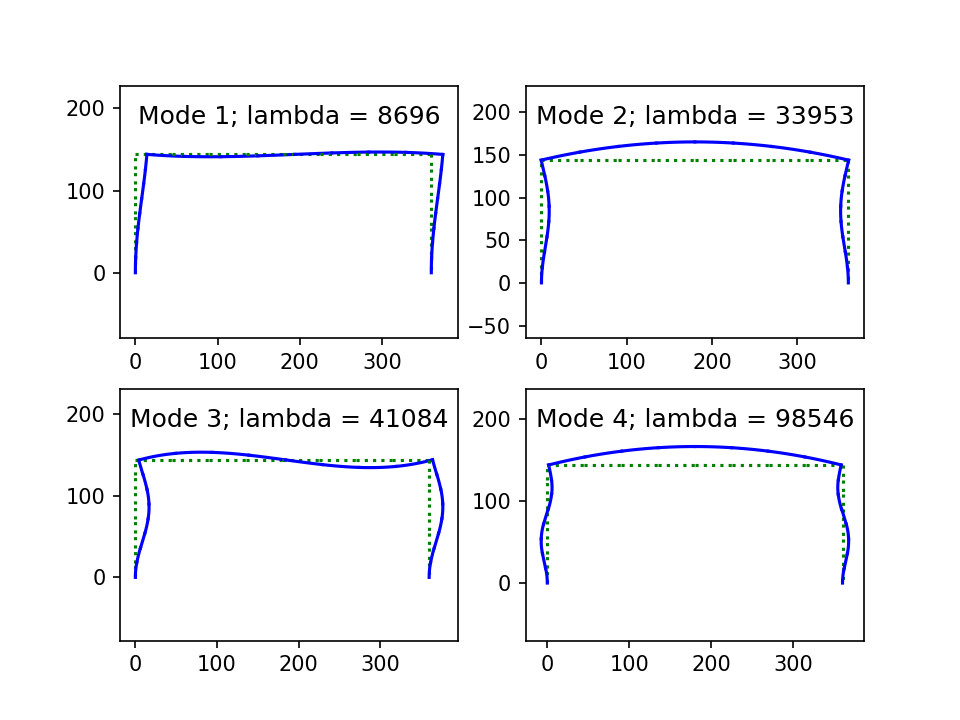

In [63]:
scale_factor = 50
lam = lam_lc1; x = x_lc1
plt.figure()
plt.subplot(2, 2, 1)
plot_buckling_mode(0,lam,x,scale_factor)   #mode 1
plt.subplot(2, 2, 2)
plot_buckling_mode(1,lam,x,scale_factor)   #mode 2
plt.subplot(2, 2, 3)
plot_buckling_mode(2,lam,x,scale_factor)   #mode 3
plt.subplot(2, 2, 4)
plot_buckling_mode(3,lam,x,scale_factor)   #mode 4
plt.show()

# Plot mode shapes for load case 2

Notice the asymmetry of the buckled shapes resulting from the asymmetric loading

<IPython.core.display.Javascript object>


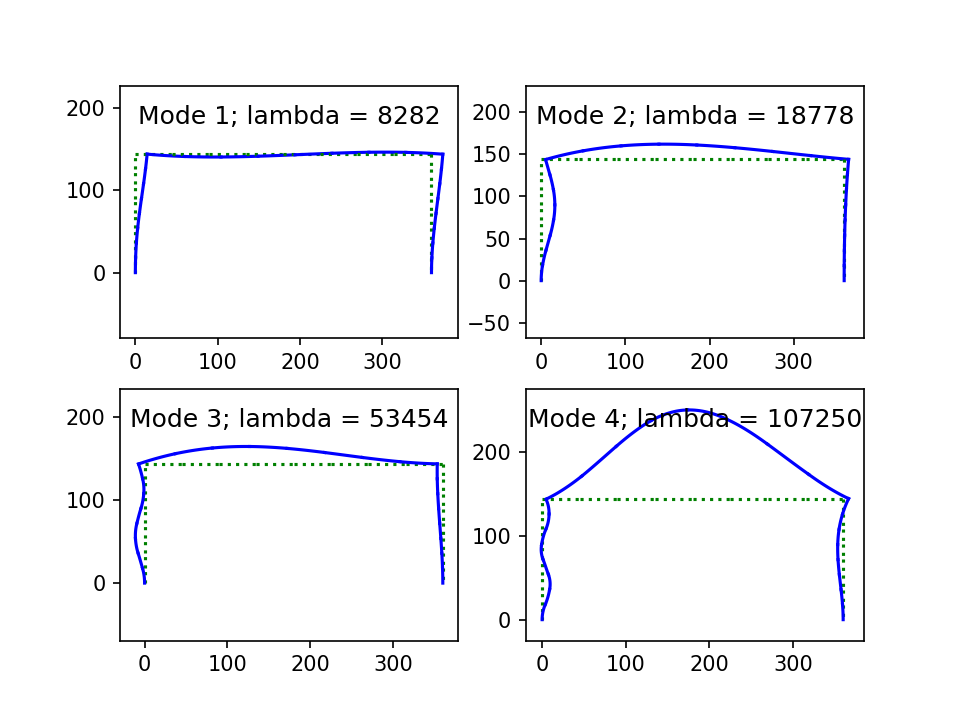

In [64]:
scale_factor = 50
lam = lam_lc2; x = x_lc2
plt.figure()
plt.subplot(2, 2, 1)
plot_buckling_mode(0,lam,x,scale_factor)   #mode 1
plt.subplot(2, 2, 2)
plot_buckling_mode(1,lam,x,scale_factor)   #mode 2
plt.subplot(2, 2, 3)
plot_buckling_mode(2,lam,x,scale_factor)   #mode 3
plt.subplot(2, 2, 4)
plot_buckling_mode(3,lam,x,scale_factor*4)   #mode 4
plt.show()